In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [5]:
USELESS_DATA_BOUNDARY= 0.3
FEATURE_FILTER_BOUNDARY = 0.03

In [4]:
class DataSet(object):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.processed_data = self.data

        #self.raw_predictor = self.data.iloc[:,:-1].values
        #self.raw_response = self.data.iloc[:,-1].values

        self.useless_value_process()
        self.missing_value_process()
        self.tag_transfer()
        self.imputer_process()
        self.normalize()
        self.feature_filter()

    def useless_value_process(self):
        col_del = ['examide', 'citoglipton', 'glimepiride-pioglitazone','encounter_id','patient_nbr']
        self.processed_data.drop(col_del, axis=1, inplace = True)
    
    def missing_value_process(self):
        row_num = len(self.data)
        col_num = len(self.data.columns)
        cols_to_drop = []
        # Check all the features
        for col in range(col_num):
            # qm is short for Question Mark, which indicates a missing value
            qm_num = 0
            for row in range(row_num):
                # Check if the value is missing
                if str(self.data.iat[row,col]) == "?":
                    qm_num += 1

            # Print(qm_num/row_num), the percentage of missing values
            if qm_num/row_num >= USELESS_DATA_BOUNDARY:
                # Print("true") if the percentage is greater than the set boundary, and add the column to columns to drop
                cols_to_drop.append(self.data.columns[col])
        # Drop column
        self.processed_data.drop(columns=cols_to_drop, axis=1, inplace = True)

    def imputer_process(self):
        # Replace the question marks with the most frequently appeared value for each feature
        imp = SimpleImputer(missing_values= -1, strategy='most_frequent')
        imp.fit(self.processed_data)

    def tag_transfer(self): 

        le = LabelEncoder()
        #self.processed_data.replace('?', -1, inplace=True)
        value_to_keep = "?"

        # 遍历DataFrame的每一列
        for column in self.processed_data.columns:
            # 如果列的数据类型是对象（通常意味着它是分类类型）
            if self.processed_data[column].dtype == 'object':
                # 对列应用 LabelEncoder
                values_to_encode = self.processed_data[column] != value_to_keep
                #original_column = self.processed_data[column].copy()
                # 对非特定值应用 LabelEncoder
                encoded_values = le.fit_transform(self.processed_data.loc[values_to_encode, column])
                self.processed_data[column] = le.fit_transform(self.processed_data[column])
                self.processed_data[column].fillna(self.processed_data[column], inplace=True)

    def get_integer_mapping(self, le):
    
        res = {}
    
        for cl in le.classes_:
    
            res.update({cl:le.transform([cl])[0]})
    
        return res

    def normalize(self):

        # Normalize data using StandardScaler
        scaler = StandardScaler()
        self.normalized_data = scaler.fit_transform(self.processed_data)

        # Print normalized data
        print(self.normalized_data)

    def feature_filter(self):
        importances = self.processed_data.drop('readmitted', axis=1).apply(lambda x: x.corr(self.processed_data.readmitted))
        indices = np.argsort(importances)
        print(importances[indices])

        names=[]
        for col in self.processed_data.columns:
            names.append(col)
        names.remove("readmitted")

        # plt.title('Readmitted')
        # plt.barh(range(len(indices)), importances[indices], color='g', align='center')
        # plt.yticks(range(len(indices)), [names[i] for i in indices])
        # plt.xlabel('Relative Importance')
        # plt.show()

        for i in range(0, len(indices)):
            if np.abs(importances[i]) > FEATURE_FILTER_BOUNDARY:
                print(names[i])

In [5]:
train_data = DataSet('diabetic_data.csv')
test_data = DataSet('diabetic_data_test.csv')

#train_data.data

#test_data.processed_data
train_data.processed_data.to_csv("test.csv",index=False)
np.savetxt("test_csv.csv", train_data.normalized_data, delimiter=",")

number_inpatient           -0.234283
number_diagnoses           -0.104820
number_emergency           -0.103024
number_outpatient          -0.068552
time_in_hospital           -0.057718
diabetesMed                -0.057306
num_medications            -0.051772
num_lab_procedures         -0.037976
admission_source_id        -0.031816
age                        -0.030271
repaglinide                -0.019256
race                       -0.015184
discharge_disposition_id   -0.012450
glipizide                  -0.011591
acarbose                   -0.008583
diag_3                     -0.008325
rosiglitazone              -0.006756
pioglitazone               -0.005238
A1Cresult                  -0.003312
insulin                    -0.003113
nateglinide                -0.003039
diag_2                     -0.002351
glipizide-metformin        -0.001980
acetohexamide              -0.001959
glyburide-metformin        -0.001552
troglitazone               -0.000748
chlorpropamide              0.001134
m

In [6]:
# export the normalized data as an Excel file
#df = pd.read_csv('test_csv.csv')
#df.to_excel('normalized_new_dataset.xlsx', index = False, header=True)

In [7]:
train_data = pd.read_csv('diabetic_data.csv')
test_data = pd.read_csv('diabetic_data_test.csv')

predictor = train_data.iloc[:,:-1].values
response = train_data.iloc[:,-1].values

predictor,response 

(array([[2278392, 8222157, 'Caucasian', ..., 'No', 'No', 'No'],
        [149190, 55629189, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [64410, 86047875, 'AfricanAmerican', ..., 'No', 'No', 'Yes'],
        ...,
        [443854148, 41088789, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [443857166, 31693671, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [443867222, 175429310, 'Caucasian', ..., 'No', 'No', 'No']],
       dtype=object),
 array(['NO', '>30', 'NO', ..., 'NO', 'NO', 'NO'], dtype=object))

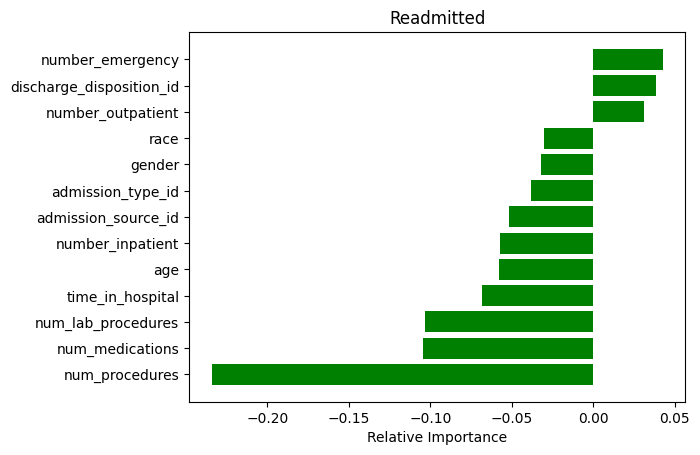

In [18]:
# Relative importance
processed_data = pd.read_csv('test_csv.csv')
importances = processed_data.drop('readmitted', axis=1).apply(lambda x: x.corr(processed_data.readmitted))

names=[]
for col in processed_data.columns:
    names.append(col)
names.remove("readmitted")

indexes_to_drop = []
for i in range(0, len(importances)):
    if np.abs(importances[i]) <= FEATURE_FILTER_BOUNDARY:
        indexes_to_drop.append(i)
importances = importances.drop(importances.index[indexes_to_drop])

indices = np.argsort(importances)

plt.title('Readmitted')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

101766
change 'No' and readmitted 'NO': 30.150541438201362%
change 'No' and readmitted '<30': 5.698366841577737%
change 'No' and readmitted '>30': 17.955898826720123%
change 'Ch' and readmitted 'NO': 23.7613741328145%
change 'Ch' and readmitted '<30': 5.461549043884991%
change 'Ch' and readmitted '>30': 16.97226971680129%


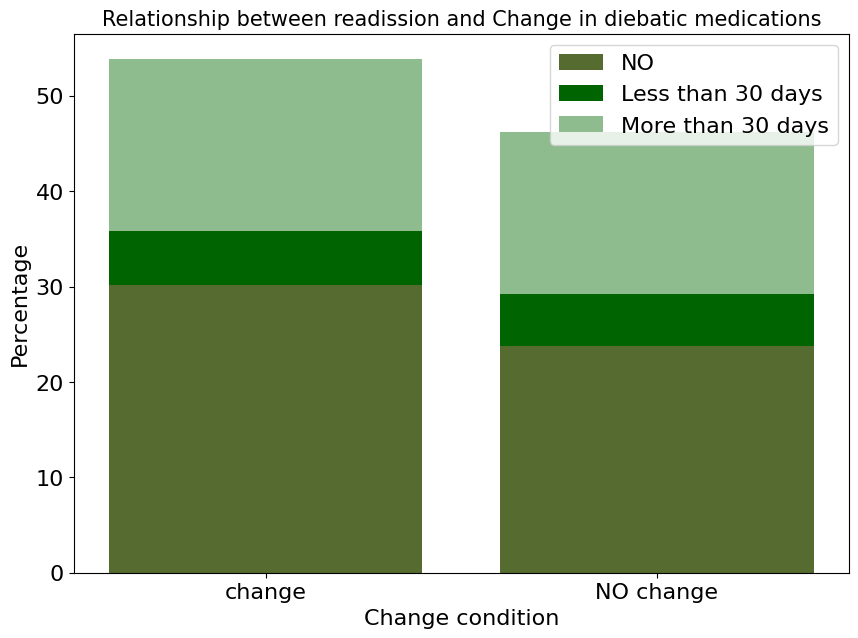

101766
diabetesMed 'No' and readmitted 'NO': 13.688265235933416%
diabetesMed 'No' and readmitted '<30': 2.207023956920779%
diabetesMed 'No' and readmitted '>30': 7.101585991392017%
diabetesMed 'Yes' and readmitted 'NO': 40.223650335082446%
diabetesMed 'Yes' and readmitted '<30': 8.952891928541948%
diabetesMed 'Yes' and readmitted '>30': 27.8265825521294%


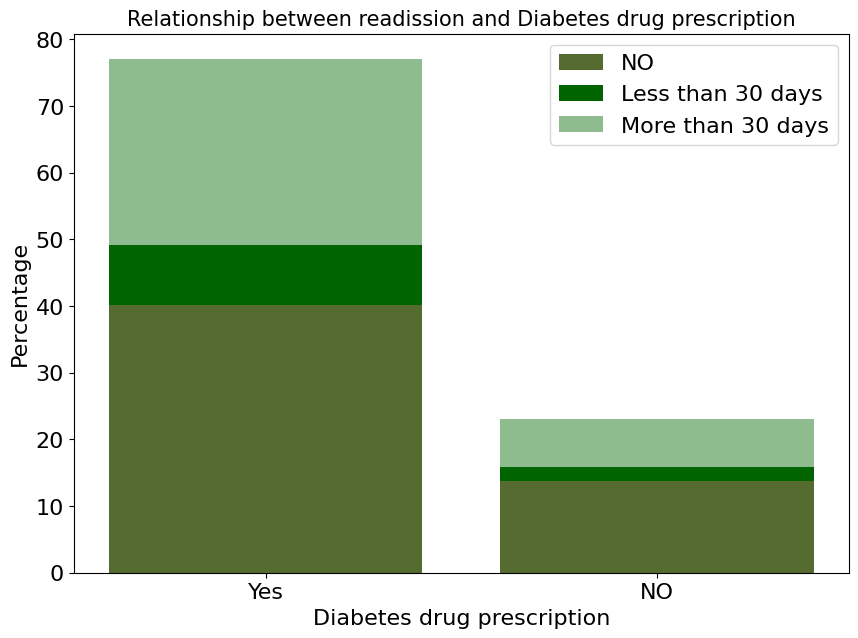

101766
metformin-pioglitazone 'No' and readmitted 'NO': 53.9109329245524%
metformin-pioglitazone 'No' and readmitted '<30': 11.159915885462727%
metformin-pioglitazone 'No' and readmitted '>30': 34.92816854352141%
metformin-pioglitazone 'Steady' and readmitted 'NO': 0.000982646463455378%
metformin-pioglitazone'Steady' and readmitted '<30': 0.0%
metformin-pioglitazone Steady' and readmitted '>30': 0.0%
metformin-pioglitazone 'Up' and readmitted 'NO': 0.0%
metformin-pioglitazone 'Up' and readmitted '<30': 0.0%
metformin-pioglitazone 'Up' and readmitted '>30': 0.0%
metformin-pioglitazone 'Down' and readmitted 'NO': 0.0%
metformin-pioglitazone'Down' and readmitted '<30': 0.0%
metformin-pioglitazone Down' and readmitted '>30': 0.0%


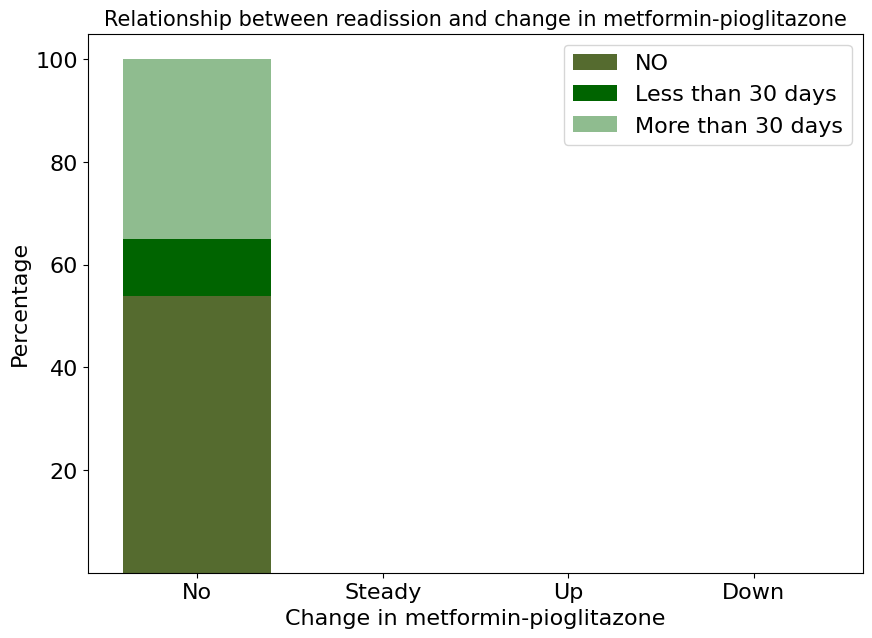

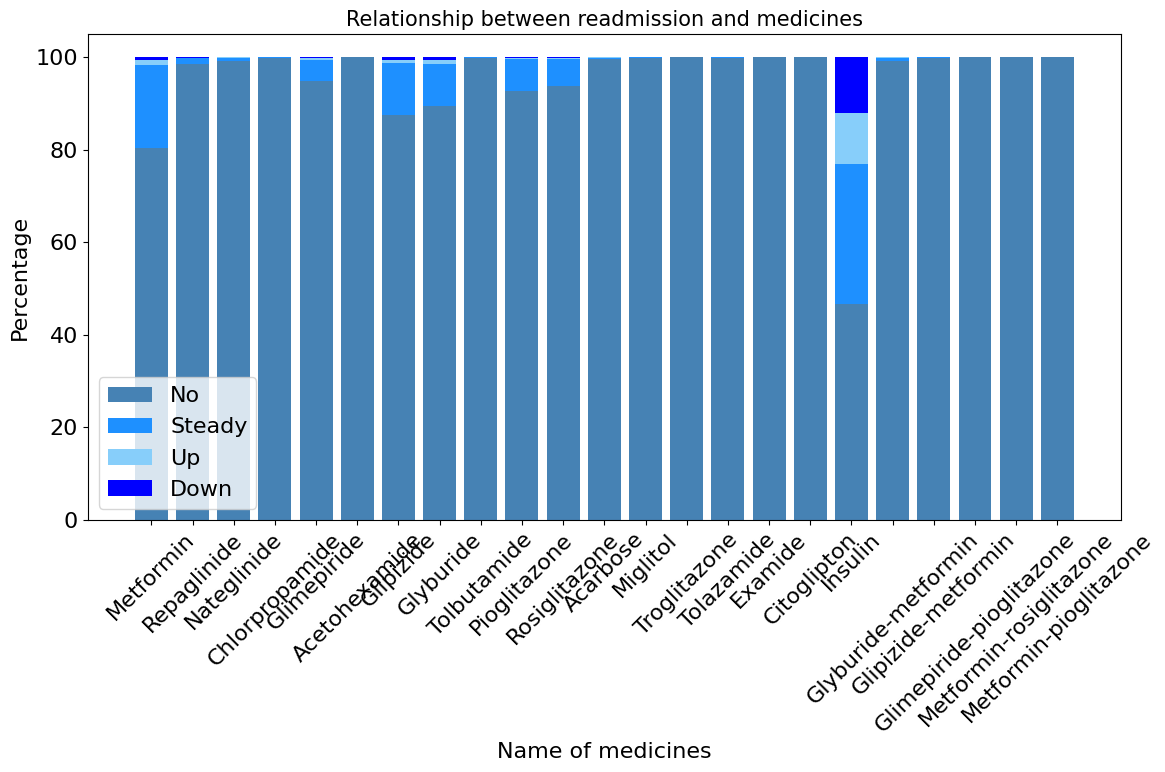

Percentage Male: 46.23842933789281%
Percentage Female: 53.75862272271682%
Percentage Unknown/Invalid: 0.0%


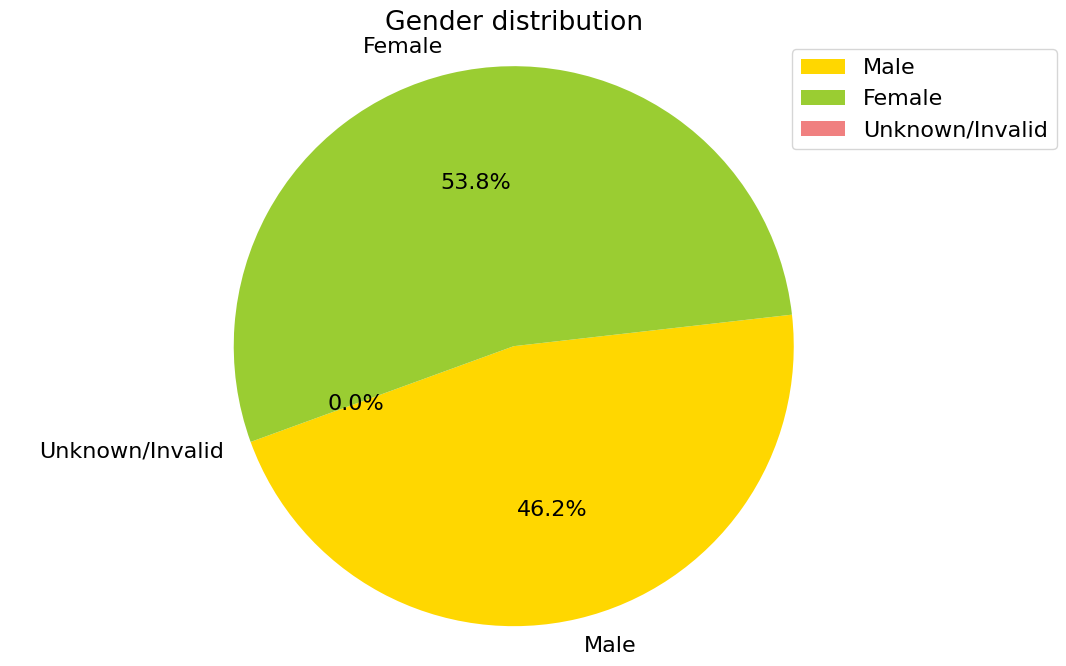

Percentage Caucasian: 74.77841322249081%
Percentage Asian: 0.6298763830748972%
Percentage African: 0.0%
Percentage American: 0.0%
Percentage Hispanic: 2.001650846058605%
Percentage Other: 1.4798655739637991%


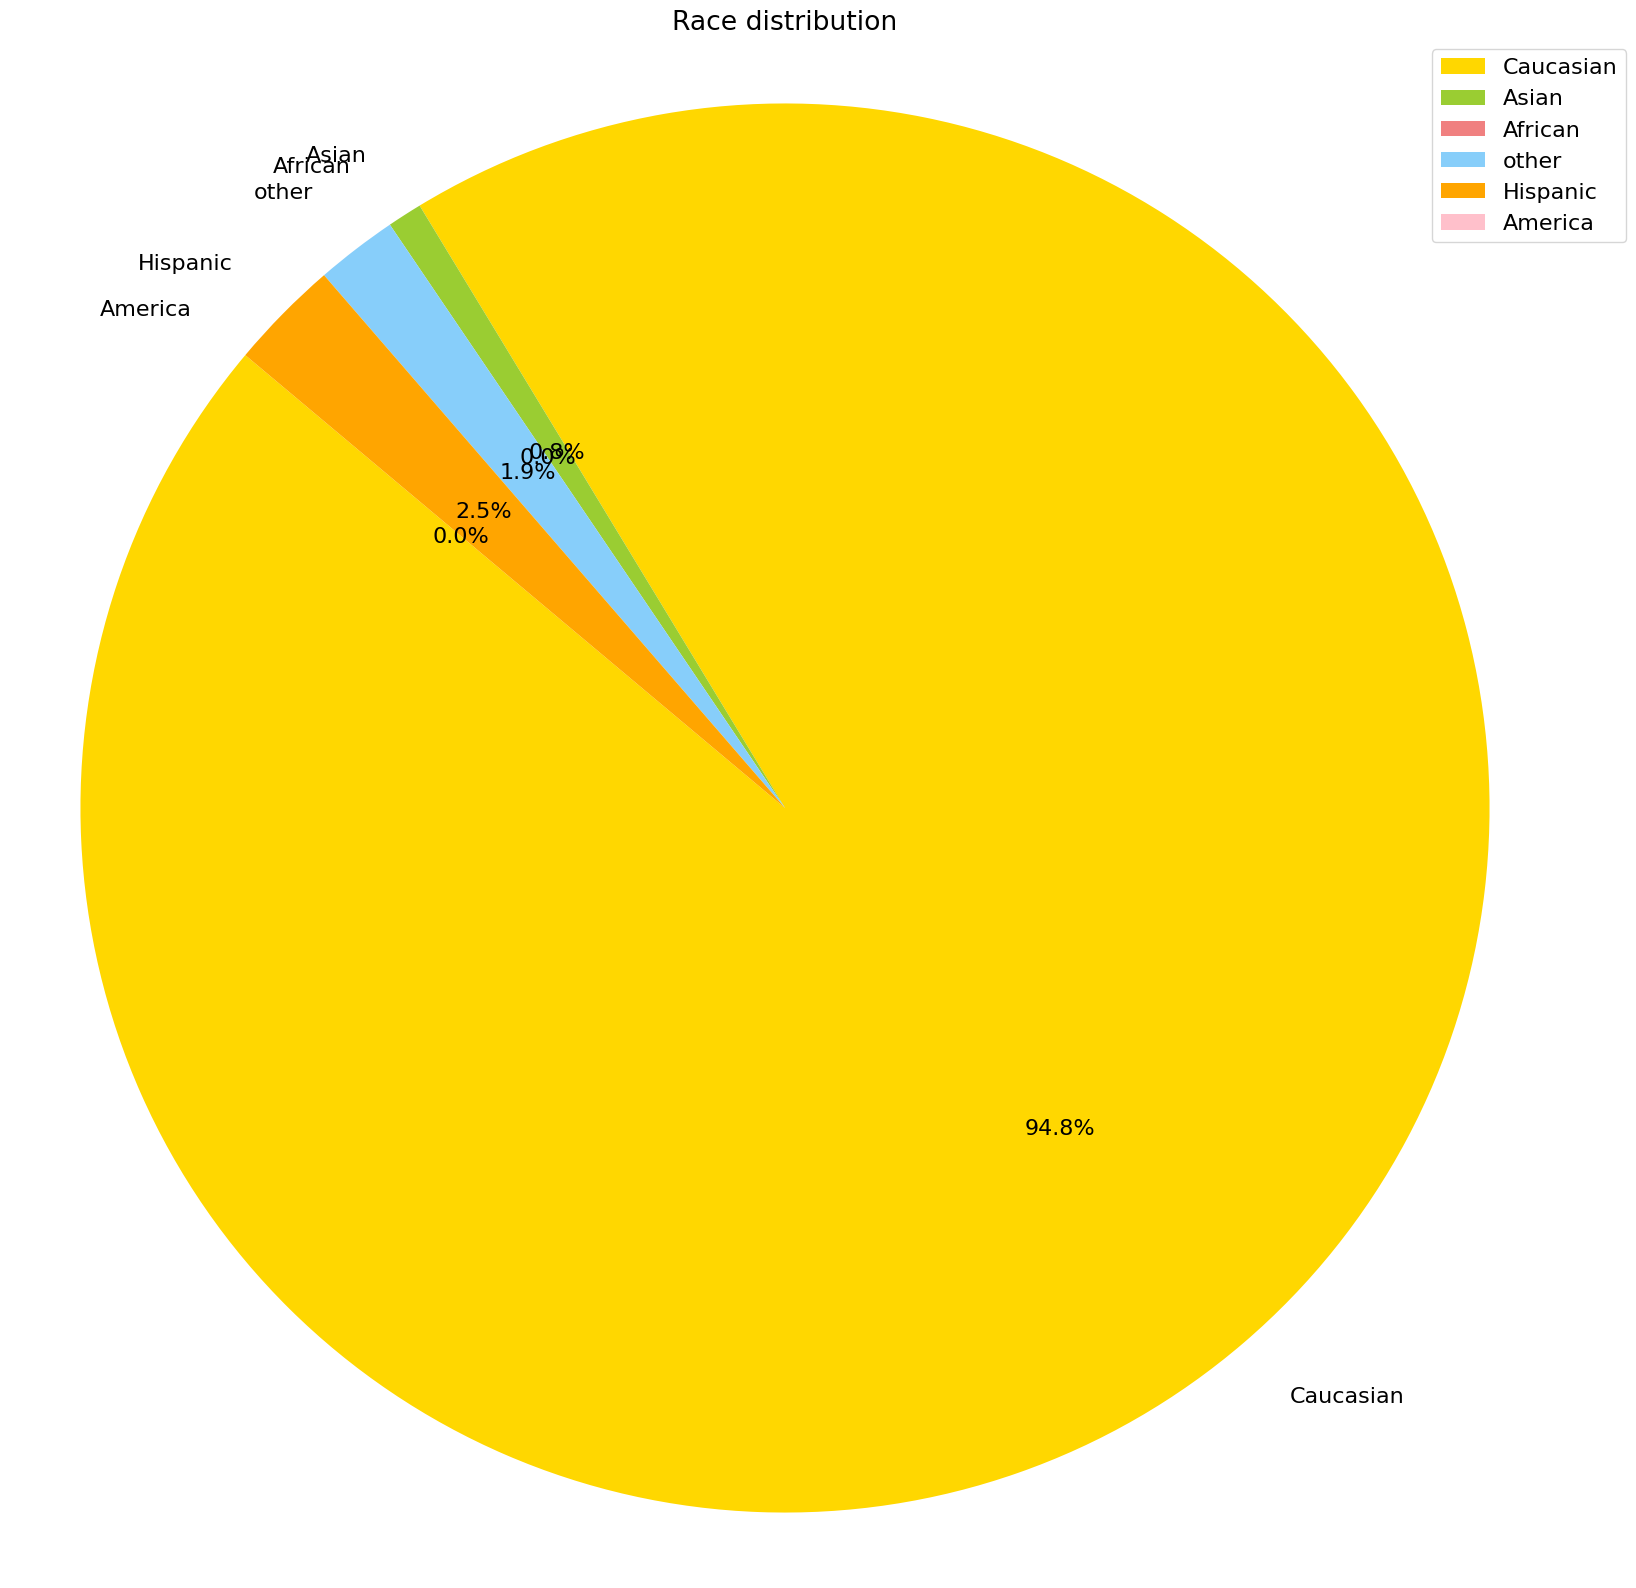

Percentage Normal: 0.00%
Percentage >200: 1.46%
Percentage >300: 1.24%
Percentage None: 94.75%


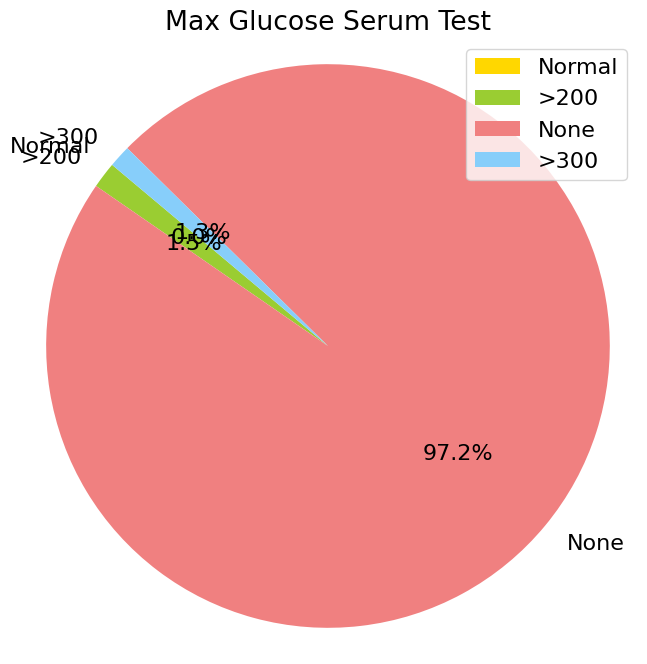

Percentage Normal: 0.00%
Percentage >8: 8.07%
Percentage >7: 3.75%
Percentage None: 83.28%


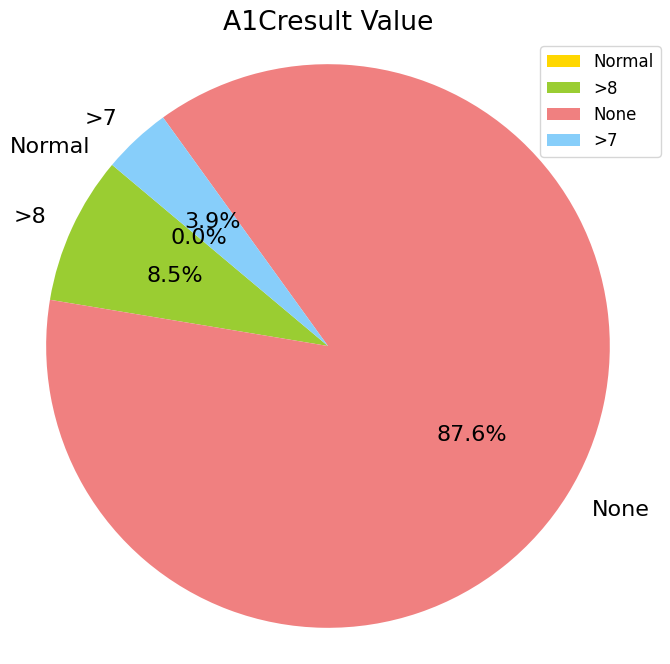

In [21]:
class DataExplorationGraph(object):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)

        # Assuming 'data' is the dataset 
        self.df = pd.DataFrame(self.data)

    def pie_race_distribution(self):
        # Plot the pie chart for Race Distribution

        # Calculate the counts for different races
        Caucasian_count = len(self.data[self.data['race'] == 'Caucasian'])
        Asian_count = len(self.data[self.data['race'] == 'Asian'])
        African_count = len(self.data[self.data['race'] == 'African'])
        American_count = len(self.data[self.data['race'] == 'American'])
        Hispanic_count = len(self.data[self.data['race'] == 'Hispanic'])
        other_count = len(self.data[self.data['race'] == 'Other'])

        total_count = len(self.data)

        # Calculate percentages
        p1 = (Caucasian_count / total_count) * 100
        p2 = (Asian_count / total_count) * 100
        p3 = (African_count / total_count) * 100
        p6 = (American_count / total_count) * 100
        p5 = (Hispanic_count / total_count) * 100
        p4 = (other_count / total_count) * 100

        print(f"Percentage Caucasian: {p1}%")
        print(f"Percentage Asian: {p2}%")
        print(f"Percentage African: {p3}%")
        print(f"Percentage American: {p6}%")
        print(f"Percentage Hispanic: {p5}%")
        print(f"Percentage Other: {p4}%")

        labels = ['Caucasian', 'Asian', 'African', 'other', 'Hispanic', 'America']
        sizes = [p1, p2, p3, p4, p5, p6]  # Portions for the pie chart

        # Set the colors
        colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange', 'pink']

        # Plot the figure
        plt.figure(figsize=(20, 20))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

        # Set the title
        plt.title('Race distribution')

        # Show the plot
        plt.axis('equal')  # Ensure it's a circle and not an ellipse
        plt.legend() 
        plt.show()

    def pie_a1cresult(self):
        # Plot the pie chart for A1Cresult Value

        # Calculate the counts for different A1Cresult categories
        normal_count = len(self.data[self.data['A1Cresult'] == 'Normal'])
        gt_8_count = len(self.data[self.data['A1Cresult'] == '>8'])
        gt_7_count = len(self.data[self.data['A1Cresult'] == '>7'])
        none_count = len(self.data[self.data['A1Cresult'] == 'None'])

        total_count = len(self.data)

        # Calculate percentages
        p1 = (normal_count / total_count) * 100
        p2 = (gt_8_count / total_count) * 100
        p3 = (gt_7_count / total_count) * 100
        p4 = (none_count / total_count) * 100

        print(f"Percentage Normal: {p1:.2f}%")
        print(f"Percentage >8: {p2:.2f}%")
        print(f"Percentage >7: {p3:.2f}%")
        print(f"Percentage None: {p4:.2f}%")

        labels = ['Normal', '>8','None', '>7']
        sizes = [p1, p2, p4, p3]  # Portions for the pie chart

        # Set the colors
        colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

        # Plot the figure
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

        # Set the title
        plt.title('A1Cresult Value')

        # Show the plot
        plt.axis('equal')  # Ensure it's a circle and not an ellipse
        plt.legend(loc='upper right') 
        plt.show()

    def stacked_medicine_use_condition(self):
        # PLot the Stacked Column Chart for Medicine use condition

        # Define all the medicines
        medicines = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']  # 添加其他药物的名称

        # create a vaccume list to fill the percentage
        percentages = []

        # write a loop to deal all of the medicines
        for med in medicines:
            # write the percentage for each medicines
            values_count = self.data[med].value_counts(normalize=True) * 100
            
            # for none value use o to replace
            for value in ['No', 'Steady', 'Up', 'Down']:
                if value not in values_count:
                    values_count[value] = 0
            
            # put the percentage into the value list
            percentages.append([values_count['No'], values_count['Steady'], values_count['Up'], values_count['Down']])

        # define medicine name
        medication_labels = [med.capitalize() for med in medicines]  # Using the first character

        # define the colour 
        colors = ["steelblue","dodgerblue", "lightskyblue", "blue"]

        # create figure
        fig, ax = plt.subplots(figsize=(12, 8))
        fig.patch.set_facecolor('white') 

        bottom = np.zeros(len(medicines))  # initialise the bottom height

        for j in range(len(percentages[0])):
            values = [percentages[i][j] for i in range(len(medicines))]
            ax.bar(medicines, values, color=colors[j], bottom=bottom, label=["No", "Steady", "Up", "Down"][j])
            bottom += np.array(values)  # update the height

        # set the title 
        ax.set_title("Relationship between readmission and medicines", fontsize=15)
        ax.set_xlabel("Name of medicines")
        ax.set_ylabel("Percentage")
        ax.legend()  

        plt.xticks(medicines, medication_labels)  # x axis is the medicine name
        plt.xticks(rotation=45)  # rotate name avoid overlap
        ax.set_ylim(0, 105) 
        plt.tight_layout()  
        plt.show()

    def histogram_age_groups(self):
        # PLot the Histogram and find the skewness of the Age groups.

        # Create a numeric mapping for age categories for all patients
        age_mapping = {age: idx for idx, age in enumerate(sorted(self.data['age'].unique()))}
        self.data['age_numeric'] = self.data['age'].map(age_mapping)

        # Calculate skewness for the age category
        age_skewness = skew(self.data['age_numeric'])

        # Plot the histogram with KDE and display the skewness on the plot
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=self.data, x='age_numeric', bins=len(age_mapping), kde=True, kde_kws={"bw_adjust": 3.5})
        plt.title("Age Distribution with KDE for All Patients")
        plt.xlabel("Age Category")
        plt.ylabel("Density")
        plt.xticks(ticks=range(len(age_mapping)), labels=sorted(self.data['age'].unique()), rotation=45)
        plt.grid(True)

        # Create a second y-axis to show the count
        ax2 = ax.twinx()
        sns.histplot(data=self.data, x='age_numeric', bins=len(age_mapping), ax=ax2, alpha=0.5)
        ax2.set_ylabel('Count')

        # Annotate skewness on the plot
        ax.text(x=0.95, y=0.95, s=f"Skewness: {age_skewness:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

    def histogram_time_in_hospital(self):
        # PLot the Histogram and find the skewness of time in hospital.


        # Calculate skewness for the time in hospital
        time_in_hospital_skewness = skew(self.df['time_in_hospital'])

        # Plot the histogram with KDE and display the skewness on the plot
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=self.df, x='time_in_hospital', bins=max(self.df['time_in_hospital']), kde=True, kde_kws={"bw_adjust": 3.5})
        plt.title("Time in Hospital Distribution with KDE")
        plt.xlabel("Time in Hospital (days)")
        plt.ylabel("Density")
        plt.xticks(ticks=range(1, max(self.df['time_in_hospital']) + 1))
        plt.grid(True)

        # Create a second y-axis to show the count
        ax2 = ax.twinx()
        sns.histplot(data=self.df, x='time_in_hospital', bins=max(self.df['time_in_hospital']), ax=ax2, alpha=0.5)
        ax2.set_ylabel('Count')

        # Annotate skewness on the plot
        ax.text(x=0.95, y=0.95, s=f"Skewness: {time_in_hospital_skewness:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

        plt.show()

In [ ]:
# Heat map
import numpy as np
import pandas as pd

file_path = 'normalized_new_dataset.csv'

# Load CSV data into a Pandas DataFrame
data = pd.read_csv(file_path)

# Find the covariance matrix of the dataset
cov_matrix = np.cov(data, rowvar=False)

# Print the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the covariance matrix
cov_df = pd.DataFrame(cov_matrix, columns=data.columns, index=data.columns)

# Create a heatmap using seaborn
plt.figure(figsize=(60, 60))
sns.heatmap(cov_df, annot=True, cmap='Greens', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset 
file_path = 'normalized_new_dataset.csv'
data = pd.read_csv(file_path)

# Select the relevant features and the target variable
selected_features = [
    'number_inpatient', 'number_emergency', 'number_diagnoses',
    'number_outpatient', 'time_in_hospital', 'diabetesMed',
    'num_medications', 'change', 'num_procedures', 'num_lab_procedures', 'readmitted'
]

# Create a subset of the data with the selected features
subset_data = data[selected_features]

# Compute the covariance matrix
cov_matrix = subset_data.cov()

# Plot the covariance matrix heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap of The Most Important Features')
plt.show()